# Lab 6: Hidden Markov Model


In this lab we will look into Hidden Markov Model (HMM) to model sequential data. HMMs are based on Markov Chains as they are utilised to compute probabilities for a sequence of observed events. Moreover HMMs are based on the Markov assumption which states that the present state $z_n$ is sufficient to predict the future $z_{n+1}$ so the past $z_{0:n-1}$ can be discarded.

<img src="hmm.png" width="400">

Often, we are in a situation where the states we are interested in are hidden, we cannot observe them directly. As we will see in Exercise 2, the part-of-speech (POS) tags are hidden in a text and we can only observe the words. From these words we have to infer the tags. Similarly in Exercises 3 where a robot needs to be localised, we cannot observe the robots position but rather the measurements of its sensors. Both the tags and the robot position are called hidden variables because they are not observed.
An HMM is specified by the following components:

* A set of $N$ states.

* A transition probability matrix $A$ where each element $a_{ij}$ represents the probability of moving from state $i$ to state $j$, s.t.  $ \sum^{N}_{j=1} a_{ij} = 1$ $ \forall i$

* An emission probability distribution, the probabilities of observations $x_n$ being generated from a state $z_n$

* An initial probability distribution over states. $\pi_n$ is the probability that the Markov chain will start in state $n$. Also, $\sum^{N}_{n=1} \pi_n = 1 $


### Additional packages

For this lab we need `hmmlearn`, `nltk`, `ipywidgets` which you can install with conda:

```python
conda install -c conda-forge hmmlearn
conda install -c anaconda nltk
conda install -c conda-forge ipywidgets
```

Let's import the libraries:

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from IPython import display

import nltk
from nltk.corpus import brown
from nltk.probability import ConditionalFreqDist,ConditionalProbDist,MLEProbDist
import itertools

from sklearn.model_selection import train_test_split


# interactive display
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'

## 1) HMM with 2 states
We will start with a warm up exercise where you have to implement a HMM with 2 states and then analyse how the transition probability and emission noise influence the output. Your task is to create a function `hmm_model` that has three arguments: 
1. `switch_prob`: The probability of switching to the other state.
2. `noise_level`: The variance of the emission distribution, i.e. the measurement/observation noise.
3. `startprob`: The probabilities of starting in each state (`shape=(2,1)`).

Your function should create a [hmm.GaussianHMM](https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.GaussianHMM) model with two states (hidden states) and `covariance_type="full"`. Modify the following model attributes:
* `startprob_`: Using the `startprob` argument.
* `transmat_`: Implement a transition matrix with probability of transition for both states being $p_{transition} = $ `switch_prob`.
* `means_`: Add mean $\mu_1 = 1$ and $\mu_2 = -1$ for each state
* `covars_`: Using the the `noise_level` argument. (note: the shape should be `(2, 1, 1)`, i.e. two $1\times1$ covariance matrices)

In [34]:
def plot_hmm(model, states, observations):
    """Plots HMM states and observations for 1d states and observations.

    Args:
    model (hmmlearn model):               hmmlearn model used to get state means.
    states (numpy array of floats):       Samples of the states.
    observations (numpy array of floats): Samples of the states.
    """

    nsteps = states.size
    fig, ax1 = plt.subplots(figsize=(8,4))
    states_forplot = list(map(lambda s: model.means_[s], states))
    ax1.step(np.arange(nstep), states_forplot, "--", where="mid", alpha=1.0, c="green")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Latent State", c="green")
    ax1.set_yticks([-1, 1])
    ax1.set_yticklabels(["State 1", "State 0"])

    ax2 = ax1.twinx()
    ax2.plot(np.arange(nstep), observations.flatten(), c="blue")
    ax2.set_ylabel("Observations", c="blue")
    ax1.set_ylim(ax2.get_ylim())
    plt.show(fig)

In [35]:
# write your code here
def hmm_model(switch_prob, noise_level, startprob):
    hidden = hmm.GaussianHMM(n_components=2, covariance_type="full")
    hidden.startprob_ = startprob
    hidden.transmat_ = np.array([[1-switch_prob, switch_prob], [switch_prob, 1-switch_prob]])
    hidden.means_ = np.array([[1], [-1]])
    hidden.covars_ = np.ones((2,1,1))*noise_level
    return hidden

Next, execute the cell below to run your `hmm_model` and visualise the output with the provided `plot_hmm` function. 

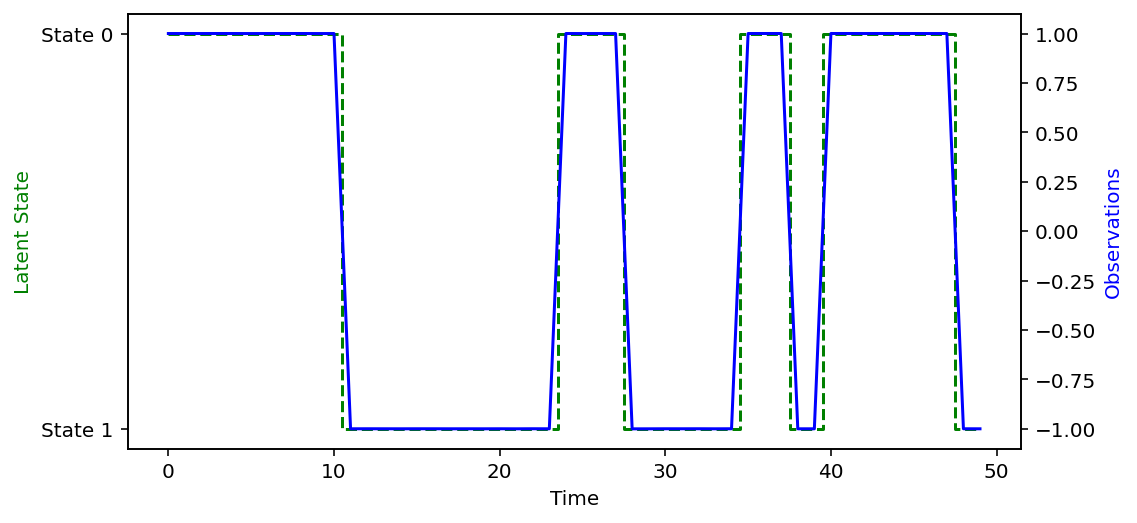

In [36]:
np.random.seed(101)
nstep = 50
model = hmm_model(switch_prob=0.1, noise_level=1e-8, startprob=np.array([1.0, 0.0]))
observations, states = model.sample(nstep)
plot_hmm(model, states, observations)

Run the cell below and experiment with the interactive widget window. Try changing the value of `switch_prob` and `noise_level`, how does that changes the output?

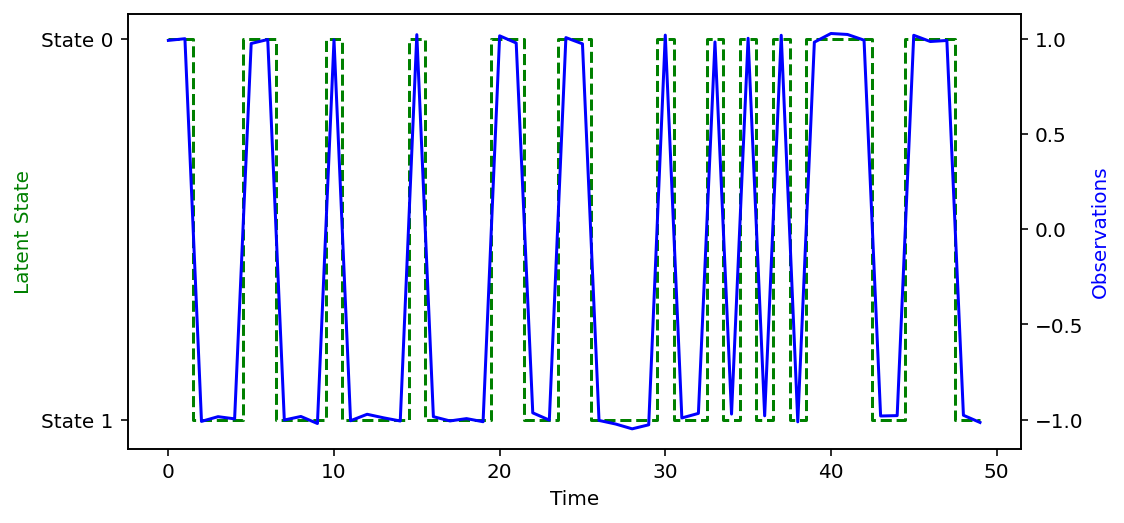

In [37]:
#@title

#@markdown Make sure you execute this cell to enable the widget!
np.random.seed(101)
nstep = 50

@widgets.interact
def plot(switch_prob=(0., 1, .01), log10_noise_level=(-8., 1., .01)):
    model = hmm_model(switch_prob=switch_prob,
                    noise_level=10.**log10_noise_level,
                    startprob=[1.0, 0.0])

    observations, states = model.sample(nstep)
    observations = observations.flatten()
    plot_hmm(model, states, observations)

## 2) HMM Part-of-Speech Tagging

Part-of-speech (POS) tagging enables the extraction of meaningful information about words in a sentence and their relation to neighbouring words. Knowing whether a word is a noun or a verb provides us information about their most likely neighboring words (such as nouns are preceded by determiners and adjectives, verbs by nouns) and syntactic structure (nouns are generally part of noun phrases), making POS tagging a key aspect of parsing. Parts of speech are useful features for labeling named entities like people or organisations in information extraction, or for coreference resolution. A word’s part of speech can even play a role in speech recognition or synthesis, e.g., the word content is pronounced CONtent when it is a noun and conTENT when it is an adjective.

Part-of-speech tagging is the process of assigning a POS marker to each word token in a given text. The input to a tagging algorithm is a sequence of tokenised words and the output is a sequence of tags, one per token. Particularly, words are ambiguous as they have more than one possible POS and the goal is to find the correct tag for each situation.
For example, "book" can be a verb ("book that flight") or a noun ("hand me that book"). The goal of POS-tagging is to resolve these ambiguities, choosing the proper tag for the context.


In this section we introduce the use of the Hidden Markov Model for part-of-speech tagging. The HMM is a sequence model that can be used as a sequence classifier is to assign a label or class to each unit in an observed sequence, thus mapping a sequence of observations to a sequence of labels. A HMM is a probabilistic sequence model: given a sequence of units (words, letters, morphemes, sentences), it computes a probability distribution over possible sequences of labels and chooses the best label sequence.

### 2.1) Brown corpus dataset
The Brown corpus is a common dataset in Natural Language Processing (NLP), it is available from the NLTK library and it supports POS tagged information. Run the cell below to download the dataset and the universal tagset.

In [38]:
# Brown dataset
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Omar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Omar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

First we need to get the dataset and split it into training and testing.
Run the following cells to achieve that and to prepare the dataset in the correct format.

In [39]:
nltk_data = list(brown.tagged_sents(tagset='universal'))
train_set,test_set = train_test_split(nltk_data,train_size=0.80,
                                     test_size=0.20,
                                     random_state=101)

In [40]:
# create list of train and test tagged words
train_tagged_words = [ tup for sent in train_set for tup in sent ]
test_tagged_words = [ tup for sent in test_set for tup in sent ]
print(f'Number of tagged words in the training set: {len(train_tagged_words)}')
print(f'Number of tagged words in the test set: {len(test_tagged_words)}')

Number of tagged words in the training set: 927092
Number of tagged words in the test set: 234100


Let's expore the different types of tags by running the next cell.

In [41]:
tags = {tag for word, tag in train_tagged_words}
print(f'Number of possible tags: {len(tags)}')
print(f'Possible tags: {tags}')

Number of possible tags: 12
Possible tags: {'NOUN', 'DET', 'PRON', '.', 'ADP', 'PRT', 'X', 'ADJ', 'NUM', 'CONJ', 'ADV', 'VERB'}


The next cell, explores the structure of the dataset in terms of words and sentences.

In [42]:
print('Words example: {}'.format(train_tagged_words[0:5]))
print('Sentence example: {}'.format(train_set[0]))

Words example: [('A', 'DET'), ('Newfoundland', 'NOUN'), ('sat', 'VERB'), ('solemnly', 'ADV'), ('beside', 'ADP')]
Sentence example: [('A', 'DET'), ('Newfoundland', 'NOUN'), ('sat', 'VERB'), ('solemnly', 'ADV'), ('beside', 'ADP'), ('a', 'DET'), ('doghouse', 'NOUN'), ('half', 'PRT'), ('his', 'DET'), ('size', 'NOUN'), ('.', '.')]


### 2.2) POS tagging model

Two of the main components of HMMs are the transition model and the emission model. You already got a taste of how the two models operate in the exercise 1. Your task now is two implement both models for POS tagging model.

Specifically, the transition model $P(tag_{t+1}|tag_t)$ will estimate the probability of the next tag given the current tag while the emission model $P(word|tag_t)$ will estimate the probability of observing a word given the current tag.

Note: the provided hints link to the `ntlk.probability` functions, however you are free to use any other libraries such as `numpy`.

#### 2.2.1) Emission Model
Given the tagged words, the main steps are:
1. Create a list of tuples ($tag, word$) from the input `words` which will be utilised in step 2. (careful: `words` contains tuples of ($word, tag$))
2. Calculate the frequency for each word given the corresponding tag. (hint: [ConditionalFreqDist](https://www.nltk.org/api/nltk.html?highlight=conditionalfreqdist#nltk.probability.ConditionalFreqDist)) 
3. Calculate the conditional probability distribution given the frequency distribution of step 2. (hint: [ConditionalProbDist](https://www.nltk.org/api/nltk.html?highlight=conditionalprobdist#nltk.probability.ConditionalProbDist) with `probdist_factory`=`MLEProbDist`)

Implement these steps in the cell below in a function `emission_model` that has one argument, `words`, containing a list of `(word, tag)` pairs.

In [63]:
# write your code here
def emission_model(words):
    new_words = []
    for word in words:
        new_words.append((word[1], word[0]))
    
    cfdist = ConditionalFreqDist()
    
    for word in new_words:
        cfdist[word[0]][word[1]] += 1
        
    cpdist = ConditionalProbDist(cfdist, probdist_factory=MLEProbDist)
    
    return cpdist

#### 2.2.2) Transition Model
Given the tagged sentences, the main steps are:
1. Create chain of tuples ($tag_{t}, tag_{t+1}$) to be passed to `ConditionalFreqDist()`. To achieve this efficiently:
    * Create a generator expression (similar to list comprehension but replacing `[]` with `()` which iterates over each sentence and for each sentence creates a pair of ($tag_{t}, tag_{t+1}$) (if you are curious about generator expressions, you can read [this](https://wiki.python.org/moin/Generators) and [this](https://realpython.com/introduction-to-python-generators/))
    * Create a chain from the ouput of the generator (hint: [itertools.chain.from_iterable()](https://docs.python.org/3.4/library/itertools.html#itertools.chain.from_iterable))
2. Calculate the frequency of the next tag given the previous tag. (hint: [ConditionalFreqDist](https://www.nltk.org/api/nltk.html))
3. Calculate the conditional probability distribution of the next tag given the previous tag. (hint: [ConditionalProbDist](https://www.nltk.org/api/nltk.html))

Implement these steps in the cell below in a function `transition_model` that has one argument, `sentences`, containing the dataset of sentences.

In [70]:
# write your code here
def transition_model(sentences):
    cfdist = ConditionalFreqDist()
    
    for sentence in sentences:
        for i in range(0, len(sentence)-1):
            cfdist[sentence[i][1]][sentence[i+1][1]] += 1

    cpdist = ConditionalProbDist(cfdist, probdist_factory = MLEProbDist)
    
    return cpdist

Utilising the previously created models, the cell below trains the emission and transition models, the former using tagged words and the later on tagged sentences.

In [71]:
emission_p = emission_model(train_tagged_words)
transition_p = transition_model(train_set)

Based on the Brown corpus, the trained HMM gives the following probabilities:
* The probability of observing the world `city` given the tag `NOUN`.
* The probability of the tag `VERB` given the tag `NOUN`.

In [72]:
p_city_NOUN = emission_p['NOUN'].prob('city')
p_VERB_NOUN = transition_p['NOUN'].prob('VERB')
print('p(city|NOUN) = ', p_city_NOUN)
print('p(VERB|NOUN) = ', p_VERB_NOUN)

p(city|NOUN) =  0.0009174311926605505
p(VERB|NOUN) =  0.15875670429120206


### 2.3) Viterbi algorithm

The goal of the Viterbi algorithm is to find the most likely sequence of hidden states for a given sequence of observations. Specifically, we will utilise the Viterbi algorithm to find the tags of a sequence of untagged sentences, known as $decoding$. 
The benefit of this algorithm comes from its ability to efficiently determine the most probable path amongst the exponentially many possibilities. Doing so, it can reduce the complexity from $O(N^T)$ to $O(NT)$ where $N$ is the total number of words and $T$ is the total number of tags.

Your task is to implement Viterbi algorithm and perform HMM decoding.
Complete the missing `to-do` lines.


In [91]:
def viterbi(observed_seq, states, start_p, transition_p, emit_p):
    eps = 0.00000001
    
    # Initialise the list, V, that will contain a dictionary for each element in the sequence. Each dictionary 
    # has the possible states (tags) as keys and its values are a dictionary with the keys:
    # 'prob': the probability of the sequence until this point
    # 'prev': the previous state used for backtracking.
    V = [dict()] 
    for state in states:
        V[0][state] = {"prob": start_p[state] * emit_p[state].prob(observed_seq[0]), "prev": None}

    # Run Viterbi for t > 0
    for t in range(1, len(observed_seq)):
        V.append({})
        for state in states:
            # In the forward pass, for each element of the observed_seq we want to store the maximum 
            # probability for the each state as well as the previous state. This probability is the product of
            # the maximum transition probability and the emission probability.
            
            # First we calculate the max_transition_prob by going through all the combinations between states.
            
            # The next line should initialise the max_transition_prob given by the product between the prob of 
            # the first state (of the sequence till t-1) and the transition probability from the first state 
            # to the current state  
            max_transition_prob = V[t-1][states[0]]['prob'] * transition_p[states[0]].prob(state)
            
            prev_state_selected = states[0]
            for prev_state in states[1:]:
                # next we calculate each possible transition probability given by the product between 
                # the prob of the previous state (of the sequence t-1) and the transition probability from  
                # the previous to the current state.
                transition_prob = V[t-1][prev_state]['prob'] * transition_p[prev_state].prob(state)
                
                #update the maximum transition_prob accordingly
                if transition_prob > max_transition_prob:
                    max_transition_prob = transition_prob
                    prev_state_selected = prev_state
                    
            # Calculate the max_prob given by the product of the maximum transition probability and the 
            # emission probability . Remember to add eps to each probabilities before multiplying them together
            max_prob = (max_transition_prob + eps) * (emit_p[state].prob(observed_seq[t]) + eps)
            
            V[t][state] = {"prob": max_prob, "prev": prev_state_selected}

    most_likely_seq = []
    max_prob = 0.0
    previous = None
    # Get most probable final state before backtracking
    for state, data in V[-1].items():
        if data["prob"] > max_prob:
            max_prob = data["prob"]
            best_state = state
    most_likely_seq.append(best_state)
    previous = best_state

    # Backtrack until the first observation
    for t in range(len(V) - 2, -1, -1):
        # add the most likely tag to the most_likely_seq. Remember: we are backtracking hence we need to 
        # add before the last tag (hint: most_likely_seq.insert() )
        # TO-DO
        most_likely_seq.insert(0, V[t+1][previous]["prev"])
        
        previous = V[t + 1][previous]["prev"]

# print ('The steps of states are ' + ' '.join(most_likely_seq) + ' with highest probability of %s' % max_prob)

    return list(zip(observed_seq, most_likely_seq))

Run the cell below to get `n=10` random sentences as test data (untagged words).

In [92]:
import random, time
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(1234)      #define a random seed to get same sentences when run multiple times

n = 10
# n = 11468 # whole test set
# choose random n numbers
rndom = [random.randint(1,len(test_set)) for x in range(n)]

# list of 10 sentences on which we test the model
test_run = [test_set[i] for i in rndom]
 
# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
 
# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

Run the cell below to check your implementation of the Viterbi algorithm on the test set and its POS tagging accuracy.

In [93]:
possible_tags = list(set([pair[1] for pair in train_tagged_words]))
start_pr = {}
for tag in possible_tags:
    start_pr[tag] = 1.0/len(possible_tags)
    
start = time.time()
predicted_tags = viterbi(test_tagged_words, possible_tags, start_pr, transition_p, emission_p)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy 
predicted_correct = [i for i, j in zip(predicted_tags, test_run_base) if i == j]  

accuracy = len(predicted_correct)/len(predicted_tags)
print('Viterbi Algorithm Accuracy: ', accuracy*100)


Time taken in seconds:  0.013995885848999023
Viterbi Algorithm Accuracy:  97.05882352941177


Let's print the print the first 10 words and their predicted tags.

In [94]:
predicted_tags[0:10]

[('I', 'PRON'),
 ('forced', 'VERB'),
 ('confidence', 'NOUN'),
 ('into', 'ADP'),
 ('myself', 'PRON'),
 ('.', '.'),
 ('Falling', 'VERB'),
 ('somewhere', 'ADV'),
 ('in', 'ADP'),
 ('a', 'DET')]

as well as the mispredicted tags:

In [95]:
for i, j in zip(predicted_tags, test_run_base):
    if i != j:
        print(i,j)

('undeniably', 'VERB') ('undeniably', 'ADV')
('there', 'PRT') ('there', 'ADV')
('that', 'PRON') ('that', 'DET')
('wetly', 'NOUN') ('wetly', 'ADV')


How well does the model predicts? Can you make any observations regarding the wrongly-predicted tags?

## 3) Robot localisation -- Optional

Another application of HMM application is robot localisation, which is the focus of this exercise. 

We have a robot which is deployed to Mars to collect some samples. However, during the landing phase, the connection got temporarily lost and we are not sure where exactly the robot is. Luckily, the map of the area is available and the robot is provided with a sensor that can detect rocky surface.

The aim is to utilised HMM to localise the robot where the hidden variable $z$ is the position of the robot and the observation $x$ is given by the sensor measurement. 
The figure at the top of the lab sheet, taken from Bishop, shows the relation between hidden variables $z$ with the observable variables $x$.  

We will achieve this through the discrete case of the Bayes Filter which consists of mainly two steps:
prediction step and measurement step. Your task will be to implement these two steps which is given by the following pseudocode.

First step:
$$ \overline{p}_{k,t} = \sum_i p(z_k | u_t, z_i) p_{i, t-1} $$
where:
* $\overline{p}_{k,t}$: the predicted belief of the new state $z_k$ at the current time $t$ based on the action (control $u_t$). 
* $p_{i, t-1}$: the belief of state $z_i$ at the previous time step $t_1$
* $p(z_k | u_t, z_i)$ : the transition probability of moving from state $z_i$ to state $z_k$ when taking action $u_t$.

In the second step, the knowledge from the measurement model $p(x_t | z_k)$ is combined with the predicted belief $\overline{p}_{k,t}$ to obtain the posterior belief $p_{i, t-1}$ of each state. This posterior belief becomes the current belief for the next time step.

$$ p_{i, t} = \eta p(x_t | z_k) \overline{p}_{k,t}  $$
$p(x_t | z_k)$ is also known as the likelihood, i.e. how likely it is to see an observation given the robot is in location $z_k$. We need to get the likelihood before implementing the belief. Moreover $\eta$ is the normalising term such that the probability adds to 1.

We provide the implementation of both World and Robot class:

In [0]:
class World():
    def __init__(self,start=(0,0),N=15):
        self.world = np.zeros((N,N))
        self.world[0,:] = 1
        self.world[-1,:] = 1
        self.world[:,0] = 1
        self.world[:,-1] = 1
        self.world[5, 6:12] = 1
        self.world[6:11, 9] = 1
        self.world[7:10, 6] = 1
        self.world[11, 4:10] = 1
        self.N = N
    
    def get_world(self):
        return self.world
    def set_world(self,N):
        self.world = np.zeros((N,N))
    def show_world(self):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
        ax.set_xticks(np.arange(-.5, self.N, 1));
        ax.set_yticks(np.arange(-.5, self.N, 1));
#         ax.axis('off')
        im = ax.imshow(self.world)
        plt.colorbar(im)
        plt.show()
        
    

The robot has 4 possible actions: up, down, left and right. Each action will transition the robot in the new state with probability `p_move`. At each state the robot can measure whether the surface is rocky or normal by calling `measurement()` with the sensor's noise value of `p_sense`.

In [0]:
class Robot:
    def __init__(self, p_move, p_sense, world):
        self.location = np.random.randint(0,world.shape[0],2)
        self.p_move = p_move
        self.p_sense = p_sense
        self.world =  world
        self.N = self.world.shape[0]
        self.possibleActions = ['U', 'D', 'L', 'R']
        self.tracking_error = []
        self.homing_error = []

    # The robot transition are noisy with prob_move to follow the action and (1-p_move) of staying
    # in the same location
    def transition(self,action):
        if (np.random.rand() < self.p_move):
            if(action == 'U' ):
                self.location =  (max(0,self.location[0]-1), self.location[1])
            elif(action == 'R'):
                self.location = (self.location[0], min(self.N-1,self.location[1]+1))
            elif(action == 'D'):
                self.location = (min(self.N-1,self.location[0]+1), self.location[1])
            elif(action == 'L'):
                self.location = (self.location[0], max(0,self.location[1]-1))
            
        return self.location

    # Measurement model which returns 1 when the surface is rocky and 0 otherwise.
    # As in transition model, the sensor can be noisy with p_sense of returning the correct value.
    def measurement(self):
        if (np.random.rand() < self.p_sense):
            return self.world[int(self.location[0]),int(self.location[1])]
        else:
            if self.world[int(self.location[0]),int(self.location[1])] == 0:
                return 1
            else:
                return 0

    # transition model of the robot assuming no noise
    def transition_no_noise(self,location,action):
        if(action == 'U' ):
            location =  (max(0,location[0]-1), location[1])
        elif(action == 'R'):
            location = (location[0], min(self.N-1,location[1]+1))
        elif(action == 'D'):
            location = (min(self.N-1,location[0]+1), location[1])
        elif(action == 'L'):
            location = (location[0], max(0,location[1]-1))
            
        return location

    def visualise_true_position(self):
        x = self.world.copy()
        x[int(self.location[0]),int(self.location[1])] = 0.5
#         x[int(self.home[0]),int(self.home[1])] = 0.7

        return x

The map is discrete and represented through grids where each grid indicates a position. 
As displayed below, the yellow corresponds to the rocky surface while the purple corresponds to the normal surface. The sensor measurement will output a value of 1 for the rocky surface and a value of 0 for the normal surface.

In [0]:
world = World(15)
world.show_world()

Run the following two cells to initialise the robot class and show the starting position.

In [0]:
p_move = .9  # original value 0.9
p_sense = .8 # original value 0.8
N = 15
# Initialise belief in position - uniform distribution over world
state_belief = np.ones((N,N))/(N*N)

robot = Robot(p_move,p_sense,world.get_world())

In [0]:
plt.imshow(robot.visualise_true_position());

The next cell provides helper functions to visualise the true robot position, the predicted belief, the likelihood and the posterior belief.

In [0]:
# helper function to visualise 
def show(robot, predicted_state_belief, likelihood, state_belief):
    plt.clf()
    plt.subplot(2,4,1)
    plt.cla()
    plt.imshow(robot.visualise_true_position())
    plt.title('True position in world')
    
    plt.subplot(2,4,2)
    plt.cla()
    plt.imshow(predicted_state_belief)
    plt.title('Predicted belief given action')
    
    plt.subplot(2,4,3)
    plt.cla()
    plt.imshow(likelihood)
    plt.title('Likelihood')
    
    plt.subplot(2,4,4)
    plt.cla()
    plt.imshow(state_belief)
    plt.title('Posterior belief given measurement')

The next cell contains the main algorithm and your task is to fill the missing lines `to-do` (hint: check the provided pseudocode above).

In [0]:
# Run the discrete Bayes filter
plt.figure(figsize=(15,9))

N = 15
steps = 100
# Create list of possible states in world (x,y coordinates)
possible_states = np.array(np.meshgrid(np.linspace(0,N-1,N),np.linspace(0,N-1,N))).reshape(2,-1).T

for step in range(steps):
    
    # Sample a random action
    a = np.random.choice(['U','D','L','R'])
    
    # Move the robot according to the action and sense the measurement
    state = robot.transition(a)
    measurement = robot.measurement()
    
    # Make prediction about state belief given action
    predicted_state_belief = np.zeros((N,N))
    
    for state in possible_states.astype(int):
        
        new_state = robot.transition_no_noise(state,a)
        
        predicted_state_belief[state[0],state[1]] = # TO-DO
   
    # Evaluate sensor belief for each possible state
    likelihood = np.zeros((N,N))
    for state in possible_states.astype(int):
        
        match = measurement == world.get_world()[state[0],state[1]]
        likelihood[state[0],state[1]] = # TO-DO
    
    # Compute posterior belief over possible states
    state_belief = # TO-DO
    
    # normalising
    state_belief = (state_belief+1e-15)
    state_belief = state_belief/np.sum(state_belief) 
    
    # Make a function to display
    show(robot, predicted_state_belief, likelihood, state_belief)

    display.clear_output(wait=True)
    display.display(plt.gcf())

Change the `p_move` and `p_sense` values and re-run the experiment with different values. How these probabilities affect the performance?

## Wrap-up

Congratulations, you have reached the end of this lab. Let's summarise what we have learnt:
* Understand the role of the HMM components 
* Key applications of HMM such as POS tagger
* Perform POS tagging through the transition model and the emission model.
* Implemented the Viterbi algorithm and the discrete Bayes filter algorithm.


## References

* COMS30035 Machine Learning
* Bishop - Pattern Recognition and Machine Learning: Chapter 13 - Sequential Data
* [Probabilistic Robotics](http://www.probabilistic-robotics.org) 
* University of Edinburgh's Foundations of Natural Language Processing (FNLP) and Decision Making in Robots and Autonomous Agents (DMR) courses
* [Hussain Mujtaba](https://www.mygreatlearning.com/blog/pos-tagging/)
* [Neuromatch Academy 2020](https://www.neuromatchacademy.org)

## The End :)

<video controls src="gif.mp4" width="200">